# Import

Sem pôjde hlavička


In [1]:
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

import os
import pandas as pd
import numpy as np

import plotly.express as px

import folium

In [2]:
# Get the current working directory
current_dir = os.getcwd()

# Navigate one step above the current directory
parent_dir = os.path.dirname(current_dir)

# Construct the full path to your CSV file
csv_file_path = os.path.join(parent_dir, 'data_full.csv')

# Read the CSV file into a DataFrame
df = pd.read_csv(csv_file_path)

# Now, 'df' contains your dataset from 'C:\Users\Doktor\Documents\GitHub\Bridges\data_full.csv'

## Rename Columns

In this step, we rename the columns of the DataFrame to make them more descriptive and readable for analysis.

In [3]:
# Rename the columns
df.rename(columns={
    'ID mosta': "Bridge_ID",
    'Okres': "District",
    'Longitude': "Longitude",
    'Latitude': "Latitude",
    'Material': "Material",
    'Názov mosta': "Bridge_Name",
    'Dĺžka premostenia': "Bridge_Length",
    'Rok postavenia': "Year_of_Construction",
    'Volná šírka mosta': "Bridge_Width",
    'Normána zaťažiteľnost': "Load_Capacity",
    'Trieda PK': "Road_Class",
    'Druh konštrukcie': "Type_of_Structure",
    'Kraj': "Region",
    'n_2012': "num_2012",
    'n_2013': "num_2013",
    'n_2014': "num_2014",
    'n_2015': "num_2015",
    'n_2016': "num_2016",
    'n_2017': "num_2017",
    'n_2018': "num_2018",
    'n_2019': "num_2019",
    'n_2020': "num_2020",
    'n_2021': "num_2021",
    'n_2022': "num_2022",
    'n_2023': "num_2023",
    'Predmet premostenia': "Bridge_Purpose"

}, inplace=True)

In [4]:
columns_to_remove = [str(i) for i in range(2012, 2024)]

# Remove the specified columns
df = df.drop(columns=columns_to_remove)

### Filtering Data in Pandas DataFrame

This code snippet filters a Pandas DataFrame to select rows based on two conditions:

1. Rows where the "num_2023" column is not equal to zero.
2. Rows where the "Bridge_Length" column is not a NaN value.

It uses the `~df["Bridge_Length"].isna()` condition to check for non-NaN values in the "Bridge_Length" column and combines the conditions using the `&` operator to ensure both conditions are met.


In [5]:
classified_bridges = df[(df["num_2023"] != 0) & (
    ~df["Bridge_Length"].isna()) & (df["Bridge_Length"] != "Nezistený")]

nan_category_bridges = classified_bridges[pd.isna(
    classified_bridges["Bridge_Length"])]
len(nan_category_bridges[["Bridge_ID", "Bridge_Length"]])

0

In [6]:
classified_bridges["Road_Class"].value_counts()

Road_Class
cesta III. triedy     3955
cesta I. triedy       1899
cesta II. triedy      1473
diaľnica               737
miestna neurčená        14
účelová cesta (UC)       3
Name: count, dtype: int64

**Histogram of Bridge Length (Logarithmic Scale)**

In this plot, we visualize the distribution of bridge lengths using a histogram with a logarithmic x-axis scale. The dataset used is `classified_bridges["Bridge_Length"]`.

**Plot Details:**

- The histogram is created with logarithmic bins, enhancing the visibility of variations in bridge lengths.
- The x-axis represents "Bridge Length" in a logarithmic scale, making it suitable for visualizing a wide range of values.
- The y-axis represents the frequency of bridges within each bin.
- Each bin is annotated with the approximate mean length of bridges in that bin, displayed in meters.
- Y-axis ticks are customized to provide a clearer view of frequency.
- A semi-transparent grid is added to the y-axis for reference.

This histogram helps us understand the distribution of bridge lengths in the dataset, highlighting any trends or clusters in bridge lengths.


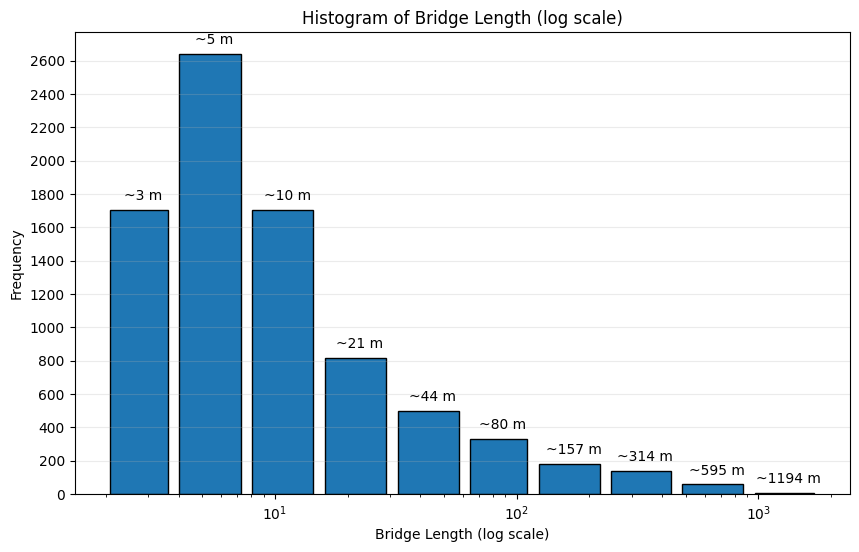

In [7]:
number_of_bins = 11
labels_blc = [str(i+1) for i in range(number_of_bins - 1)]  # Reduce by one

# Convert the "Bridge_Length" column to numeric (float) using .loc
classified_bridges = classified_bridges.copy()  # Create a copy of the DataFrame
classified_bridges.loc[:, "Bridge_Length"] = pd.to_numeric(
    classified_bridges["Bridge_Length"], errors="coerce")

# Define the parameters for the histogram plot
data = classified_bridges["Bridge_Length"]

log_bins = ([1.94,    3.75,    7.5,   15.0,  30.0,   60.0,  115.0,  230.0,
             450.0,  900.0, 1770.00])


# Create a histogram with logarithmic x-axis and adjust bin spacing (rwidth)

plt.figure(figsize=(10, 6))

hist, bins, _ = plt.hist(data, bins=log_bins, edgecolor='k', rwidth=0.85)

plt.xscale('log')  # Set x-axis to log scale

plt.xlabel("Bridge Length (log scale)")

plt.ylabel("Frequency")

plt.title("Histogram of Bridge Length (log scale)")


# Calculate and annotate the mean value for each bin

bin_means = [data[(data >= bin_start) & (data < bin_end)].mean()

             for bin_start, bin_end in zip(bins[:-1], bins[1:])]


for i, bin_mean in enumerate(bin_means):

    plt.annotate(f"~{bin_mean:.0f} m",

                 xy=(bins[i] + (bins[i + 1] - bins[i]) / 2, hist[i]),

                 xytext=(0, 5), textcoords='offset points',

                 ha='center', va='bottom')


# Customize the y-axis ticks and enable grid with transparency

# Adjust the range and step as needed

plt.yticks(np.arange(0, max(hist) + 1, 200))

plt.grid(True, axis='y', alpha=0.25)  # Set alpha for transparency

In [8]:
# Define the boundaries of the bins
bin_boundaries = list(log_bins)

# Create a list of category descriptions based on the bin boundaries
category_descriptions = [f"{bin_start:.2f} - {bin_end:.2f} m"
                         for bin_start, bin_end in zip(bin_boundaries[:-1], bin_boundaries[1:])]

# Create a dictionary to map category labels to descriptions
category_description_mapping = {label: description for label, description in zip(
    labels_blc, category_descriptions)}

# Create a new column "Bridge_Length_Category" based on the logarithmic bins
classified_bridges["Bridge_Length_Category"] = pd.cut(classified_bridges["Bridge_Length"],
                                                      bins=log_bins,
                                                      labels=labels_blc)  # Use labels as category numbers

In [9]:
# Create a copy of the "Bridge_Purpose" column
classified_bridges["Bridge_Purpose"] = classified_bridges["Bridge_Purpose"].copy()

# Use .apply() to split the strings and remove leading spaces
classified_bridges["Bridge_Purpose"] = classified_bridges["Bridge_Purpose"].apply(
    lambda x: [purpose.strip() for purpose in x.split(',')])

In [10]:
classified_bridges.columns, classified_bridges["Bridge_Purpose"].value_counts()

(Index(['Bridge_ID', 'District', 'Latitude', 'Longitude', 'Material',
        'Bridge_Name', 'Bridge_Length', 'Year_of_Construction', 'Bridge_Width',
        'Load_Capacity', 'Road_Class', 'Type_of_Structure', 'Bridge_Purpose',
        'Region', 'num_2012', 'num_2013', 'num_2014', 'num_2015', 'num_2016',
        'num_2017', 'num_2018', 'num_2019', 'num_2020', 'num_2021', 'num_2022',
        'num_2023', 'Bridge_Length_Category'],
       dtype='object'),
 Bridge_Purpose
 [Vodný tok]                                             6182
 [Kanál]                                                  468
 [Cestná komunikácia]                                     255
 [Železnica]                                              209
 [Nezistený]                                              142
                                                         ... 
 [Cestná komunikácia, Miestna komunikácia, Železnica]       1
 [Cestná komunikácia, Železnica, Iná prekážka]              1
 [Údolie, Cestná komunikácia, Ú

In [11]:
# Flatten the lists in the "Bridge_Purpose" column
exploded_purpose = classified_bridges["Bridge_Purpose"].explode()

# Count the values within the flattened Series
value_counts_within_lists = exploded_purpose.value_counts()

# Display the result
print(value_counts_within_lists)

Bridge_Purpose
Vodný tok              6532
Kanál                   506
Cestná komunikácia      364
Železnica               280
Účelová komunikácia     254
Miestna komunikácia     176
Nezistený               142
Záplavové územie        136
Iná prekážka             60
Údolie                   49
Podchod pre chodcov      25
Vodná nádrž              19
Biokoridor                4
Name: count, dtype: int64


In [16]:
bridge_id_to_find = "M2717"  # M1514 - Komárno, M3440 - Tatry, M2717 - Lupča
founded_bridge = classified_bridges[classified_bridges["Bridge_ID"]
                                    == bridge_id_to_find]

founded_bridge.columns, float(founded_bridge["Latitude"].item()), float(
    founded_bridge["Longitude"].item())

import osmnx as ox
from geopy.distance import geodesic
from shapely.geometry import Point
import pandas as pd

# Define the geolocation of the bridge
latitude = float(founded_bridge["Latitude"].item())
longitude = float(founded_bridge["Longitude"].item())
bridge_location = (latitude, longitude)

# Define a bounding box around the bridge
distance_km = 25  #  km radius
bbox = ox.utils_geo.bbox_from_point(bridge_location, dist=distance_km * 1000)

# Fetch Slovakia's boundary
slovakia_boundary = ox.geocode_to_gdf("Slovakia").geometry.iloc[0]

# Fetch Features (Points of Interest) within the bounding box
pois = ox.features_from_bbox(*bbox, tags={"place": True})

# Types of places to filter out
excluded_types = ["locality", "square", "hamlet",
                  "islet", "plot", "isolated_dwelling", "country"]

# Filter Features within  km and in Slovakia, excluding specific types
nearby_settlements = []
for idx, poi in pois.iterrows():
    geom = poi.geometry
    place_type = poi.get("place")
    population = poi.get("population")

    # Exclude certain types of places
    if place_type not in excluded_types:
        # Determine the location: use the actual coordinates if it's a Point, or the centroid if it's a Polygon
        if isinstance(geom, Point):
            poi_location = (geom.y, geom.x)
        else:
            poi_location = (geom.centroid.y, geom.centroid.x)

        # Check if the POI is within Slovakia
        if slovakia_boundary.contains(geom) or slovakia_boundary.contains(geom.centroid):
            distance = geodesic(bridge_location, poi_location).kilometers
            if distance <= distance_km:
                place_name = poi.get("name")
                nearby_settlements.append(
                    (place_name, place_type, poi_location[0], poi_location[1], population))

# Convert the nearby_settlements data to a DataFrame
df_nearby_settlements = pd.DataFrame(nearby_settlements, columns=[
                                     'Place Name', 'Place Type', 'Latitude', 'Longitude', 'Population'])


def assign_quadrant(lat, lon, bridge_lat, bridge_lon):
    if lat > bridge_lat and lon > bridge_lon:
        return 1  # North-East
    elif lat > bridge_lat and lon < bridge_lon:
        return 2  # North-West
    elif lat < bridge_lat and lon < bridge_lon:
        return 3  # South-West
    else:
        return 4  # South-East


# Convert 'Population' column to numeric, setting errors='coerce' to replace non-numeric values with NaN
df_nearby_settlements['Population'] = pd.to_numeric(
    df_nearby_settlements['Population'], errors='coerce')

# Apply the function to each row in the DataFrame to create the 'Quadrant' column
df_nearby_settlements['Quadrant'] = df_nearby_settlements.apply(
    lambda row: assign_quadrant(row['Latitude'], row['Longitude'], latitude, longitude), axis=1)


df_nearby_settlements.head(), df_nearby_settlements.shape

(  Place Name Place Type   Latitude  Longitude  Population  Quadrant
 0     Oravce    village  48.684535  19.263529       191.0         4
 1      Čerín    village  48.659947  19.246097       451.0         4
 2      Očová    village  48.599127  19.286756      2595.0         4
 3     Vígľaš    village  48.555293  19.293825      1680.0         4
 4    Hrochoť    village  48.655115  19.312248      1441.0         4,
 (118, 6))

In [17]:
from math import radians, cos, sin, asin, sqrt
# Define the haversine function for distance calculation
def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km


# Find the closest places
closest_places_data = []

for quadrant in range(1, 5):
    df_quadrant = df_nearby_settlements[(df_nearby_settlements['Quadrant'] == quadrant) &
                                        (df_nearby_settlements['Population'].notna()) &
                                        (df_nearby_settlements['Population'] > 0)].copy()

    if not df_quadrant.empty:
        df_quadrant['Distance'] = df_quadrant.apply(lambda row: haversine(longitude, latitude,
                                                                          row['Longitude'], row['Latitude']), axis=1)
        closest_place = df_quadrant.loc[df_quadrant['Distance'].idxmin()]
        closest_places_data.append(closest_place)

# Convert the list of closest places to a DataFrame
df_closest_places = pd.DataFrame(closest_places_data)

df_closest_places

,Place Name,Place Type,Latitude,Longitude,Population,Quadrant,Distance
17,Slovenská Ľupča,village,48.767361,19.275983,3163.0,1,4.192056
100,Selce,village,48.765481,19.202864,2107.0,2,3.011013
53,Horná Mičiná,village,48.698753,19.214015,509.0,3,5.273443
15,Môlča,village,48.710804,19.230346,357.0,4,3.805110


In [18]:
from math import radians, cos, sin, asin, sqrt, pi


def haversine(lon1, lat1, lon2, lat2):
    # Convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km


def get_hexagon_coordinates(center_lat, center_lon, radius):
    coordinates = []
    for i in range(6):
        angle = 2 * pi / 6 * i
        dx = radius * cos(angle)
        dy = radius * sin(angle)
        point_lat = center_lat + (180/pi) * (dy / 6378137)
        point_lon = center_lon + (180/pi) * \
            (dx / 6378137) / cos(center_lat * pi/180)
        coordinates.append((point_lat, point_lon))
    return coordinates


# Radius of the circle in meters in which hexagon is inscribed
radius = 20  # 10 meters radius in kilometers

# Create hexagon coordinates
hexagon_coords = get_hexagon_coordinates(latitude, longitude, radius)
hexagon_coords.append(hexagon_coords[0])

# Convert hexagon coordinates from (latitude, longitude) tuples to [longitude, latitude] lists
hexagon_coords_for_api = [[lon, lat] for lat, lon in hexagon_coords]

In [19]:
import folium

# Create a base map
combined_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# Add markers for the closest places
for index, row in df_closest_places.iterrows():
    name = row['Place Name']
    place_type = row['Place Type']
    lat = row['Latitude']
    lon = row['Longitude']
    population = row['Population']

    popup_text = f"{name} ({place_type}), Population: {population}"
    folium.Marker(
        location=[lat, lon],
        popup=popup_text,
        icon=folium.Icon(color="blue", icon='info-sign')
    ).add_to(combined_map)

# Add the hexagon to the map
folium.Polygon(locations=hexagon_coords, color="blue",
               fill=True, fill_color="blue").add_to(combined_map)

# Display the combined map
combined_map

In [21]:
from itertools import combinations

# Example place names from the dataframe
place_names = ["Slovenská Ľupča", "Selce", "Horná Mičiná", "Môlča"]

# Generate all combinations of 2 places from the list
place_combinations = list(combinations(place_names, 2))

place_combinations

[('Slovenská Ľupča', 'Selce'),
 ('Slovenská Ľupča', 'Horná Mičiná'),
 ('Slovenská Ľupča', 'Môlča'),
 ('Selce', 'Horná Mičiná'),
 ('Selce', 'Môlča'),
 ('Horná Mičiná', 'Môlča')]

In [62]:
routing_api_snippets = []

for combo in place_combinations:
    # Fetch the latitude and longitude for each place in the combination
    lat_lon_1 = df_closest_places[df_closest_places['Place Name'] == combo[0]][[
        'Latitude', 'Longitude']].iloc[0].tolist()
    lat_lon_2 = df_closest_places[df_closest_places['Place Name'] == combo[1]][[
        'Latitude', 'Longitude']].iloc[0].tolist()

    # Constructing the JSON snippet for the Routing API
    snippet = {
        "points": [
            [lat_lon_1[1], lat_lon_1[0]],  # Reversed to [Longitude, Latitude]
            [lat_lon_2[1], lat_lon_2[0]]
        ],
        "profile": "car",
        "points_encoded": False
    }
    routing_api_snippets.append(snippet)

# Print the pretty-formatted JSON strings
for api_string in routing_api_strings:
    print(api_string)

{
    "points": [
        [
            19.2759831,
            48.7673613
        ],
        [
            19.2028636,
            48.7654811
        ]
    ],
    "profile": "car",
    "points_encoded": false
}
{
    "points": [
        [
            19.2759831,
            48.7673613
        ],
        [
            19.214015,
            48.6987534
        ]
    ],
    "profile": "car",
    "points_encoded": false
}
{
    "points": [
        [
            19.2759831,
            48.7673613
        ],
        [
            19.2303456,
            48.7108043
        ]
    ],
    "profile": "car",
    "points_encoded": false
}
{
    "points": [
        [
            19.2028636,
            48.7654811
        ],
        [
            19.214015,
            48.6987534
        ]
    ],
    "profile": "car",
    "points_encoded": false
}
{
    "points": [
        [
            19.2028636,
            48.7654811
        ],
        [
            19.2303456,
            48.7108043
        ]
 

In [80]:
def create_routing_api_snippet_with_obstacle(coords, obstacle_coords):
    snippet = {
        "points": coords,
        "profile": "car",
        "points_encoded": False,
        "ch.disable": True,
        "custom_model": {
            "distance_influence": 15,
            "priority": [
                {
                    "if": "in_area1",
                    "multiply_by": 0
                }
            ],
            "speed": [],
            "areas": {
                "area1": {
                    "type": "Feature",
                    "geometry": {
                        "type": "Polygon",
                        # Wrap obstacle_coords in a list
                        "coordinates": [obstacle_coords]
                    },
                    "properties": {}
                }
            }
        }
    }
    return snippet

# Generate JSON snippets with an obstacle for each combination
routing_api_snippets_with_obstacle = []
for combo in place_combinations:
    lat_lon_1 = df_closest_places[df_closest_places['Place Name'] == combo[0]][[
        'Latitude', 'Longitude']].iloc[0].tolist()
    lat_lon_2 = df_closest_places[df_closest_places['Place Name'] == combo[1]][[
        'Latitude', 'Longitude']].iloc[0].tolist()

    # Create a JSON snippet with the obstacle
    snippet_with_obstacle = create_routing_api_snippet_with_obstacle(
        [[lat_lon_1[1], lat_lon_1[0]], [lat_lon_2[1], lat_lon_2[0]]],
        hexagon_coords_for_api
    )

    routing_api_snippets_with_obstacle.append(snippet_with_obstacle)

# # Print the JSON snippets with obstacles
# for api_snippet in routing_api_snippets_with_obstacle:
#     print(json.dumps(api_snippet, indent=2))

api_snippet = routing_api_snippets_with_obstacle[0]
print(json.dumps(api_snippet, indent=2))

{
  "points": [
    [
      19.2759831,
      48.7673613
    ],
    [
      19.2028636,
      48.7654811
    ]
  ],
  "profile": "car",
  "points_encoded": false,
  "ch.disable": true,
  "custom_model": {
    "distance_influence": 15,
    "priority": [
      {
        "if": "in_area1",
        "multiply_by": 0
      }
    ],
    "speed": [],
    "areas": {
      "area1": {
        "type": "Feature",
        "geometry": {
          "type": "Polygon",
          "coordinates": [
            [
              [
                19.230121666968586,
                48.745044411
              ],
              [
                19.229985436984293,
                48.74520000377133
              ],
              [
                19.22971297701571,
                48.74520000377133
              ],
              [
                19.229576747031416,
                48.745044411
              ],
              [
                19.22971297701571,
                48.744888818228674
              ],
 

In [83]:
import folium

# Initialize empty lists to store the JSON responses
graphhopper_responses = []
graphhopper_responses_alt = []

# Load JSON responses for route_1 up to route_6
for i in range(1, 7):
    file_name = f'route_{i}.json'
    file_name_alt = f'route_{i}alt.json'

    with open(file_name, 'r', encoding='utf-8') as json_file:
        response = json.load(json_file)
        graphhopper_responses.append(response)

    with open(file_name_alt, 'r', encoding='utf-8') as json_file:
        response = json.load(json_file)
        graphhopper_responses_alt.append(response)


# Define the colors for regular and alternative routes
regular_route_colors = ['#59ed97', '#75a8f0',
                        '#f0d175', '#f075a8', '#f09e75', '#bd5ad8']
alternative_route_colors = ['#16cc62', '#196ee6',
                            '#e6b219', '#e6196e', '#e65d19', '#8a27a5']


# Initialize a map
m = folium.Map(location=[latitude, longitude],
               zoom_start=12, tiles="Cartodb dark_matter")

# Define colors for regular and alternative routes
regular_route_colors = ['#59ed97', '#75a8f0',
                        '#f0d175', '#f075a8', '#f09e75', '#bd5ad8']
alternative_route_colors = ['#16cc62', '#196ee6',
                            '#e6b219', '#e6196e', '#e65d19', '#8a27a5']

# Iterate through the responses and colors
for response, alt_response, color, alt_color in zip(graphhopper_responses, graphhopper_responses_alt, regular_route_colors, alternative_route_colors):
    # Extract coordinates for regular and alternative routes
    coordinates = [(lat, lon) for lon, lat in response["paths"]
                   [0]["points"]["coordinates"]]
    coordinates_alt = [
        (lat, lon) for lon, lat in alt_response["paths"][0]["points"]["coordinates"]]

    # Create PolyLines for regular and alternative routes with respective colors
    # polyline = folium.PolyLine(locations=coordinates, color=color, weight=5)
    polyline_alt = folium.PolyLine(
        locations=coordinates_alt, color=alt_color, weight=5)

    # Add PolyLines to the map
    polyline.add_to(m)
    polyline_alt.add_to(m)

# Display the map
m

In [ ]:
graphhopper_responses
#59ed97
#75a8f0
#f0d175
#f075a8
#f09e75
#bd5ad8

graphhopper_responses_alt:
#16cc62
#196ee6
#e6b219
#e6196e
#e65d19
#8a27a5

In [20]:
df_closest_places

,Place Name,Place Type,Latitude,Longitude,Population,Quadrant,Distance
17,Slovenská Ľupča,village,48.767361,19.275983,3163.0,1,4.192056
100,Selce,village,48.765481,19.202864,2107.0,2,3.011013
53,Horná Mičiná,village,48.698753,19.214015,509.0,3,5.273443
15,Môlča,village,48.710804,19.230346,357.0,4,3.805110
